### MLP-pitmodel

base: 18./ make_pitstop_dataset-nextpit

build a pitstop dataset with <cautions_laps, pitage, gap2nextpit>
gluonts interface of Dataset = Iterable[DataEntry], DataEntry = Dict(str, any)

+ input pitstop dataset, remove pitstops with pit_oncaution = 1, refer to lapstatus_dataset-fastrun
+ context_length = 1, prediction_length = 1
+ target : gap to nextpit
+ covariates are: cautions_laps, pitage, (carid, eid)
+ modeling the distribution of nextpit-gap


In [19]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import random
import mxnet as mx
from mxnet import gluon
import pickle
import json
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import inspect
from scipy import stats
from pathlib import Path 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from gluonts.dataset.util import to_pandas
from pathlib import Path
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator, MultivariateEvaluator
from gluonts.model.predictor import Predictor
from gluonts.distribution.neg_binomial import NegativeBinomialOutput
from gluonts.distribution.student_t import StudentTOutput
from gluonts.model.forecast import SampleForecast

from indycar.model.mlp import MLPEstimator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
os.getcwd()

'/scratch_hdd/hpda/indycar/notebook/19.RankNet'

In [3]:

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def test_flag(a, bitflag):
    return (a & bitflag) ==  bitflag

#
# remove NaN at the tail
# there should be no nans in the middle of the ts
COL_LAPTIME=0
COL_RANK=1
COL_TRACKSTATUS=2
COL_LAPSTATUS=3
COL_TIMEDIFF=4
COL_CAUTION_LAPS_INSTINT=5
COL_LAPS_INSTINT= 6
COL_ELAPSED_TIME= 7
COL_LAP2NEXTPIT = 8


MODE_ORACLE = 0
MODE_NOLAP = 1
MODE_NOTRACK = 2
MODE_TESTZERO = 4
MODE_TESTCURTRACK = 8
#MODE_STR={MODE_ORACLE:'oracle', MODE_NOLAP:'nolap',MODE_NOTRACK:'notrack',MODE_TEST:'test'}

def split_ts(rec, carno, eid):
    """
    input: 
        ts
    output:
        nextpit records
    """
    output = []
    pitstops = np.where(rec[COL_LAPSTATUS,:] == 1)[0]
    
    if len(pitstops)==0:
        print('no pit ts')
        return output
    
    #pit_oncaution = np.zeros_like((pitstops))
    #for pit in pitstops:
    #    if rec[COL_TRACKSTATUS,:] == 1:
    #        pit_oncaution = 1
    pit_oncaution = np.zeros_like((rec[COL_LAP2NEXTPIT,:]))
    stint_len = np.zeros_like((rec[COL_LAP2NEXTPIT,:]))
    pos = 0
    for pit in pitstops:
        if rec[COL_TRACKSTATUS,pit] == 1:
            #next pit is oncaution
            # set pos -> pit as oncaution
            pit_oncaution[pos:pit] = 1
        else:
            pit_oncaution[pos:pit] = 0
            
        stint_len[pos:pit] = pit - pos
        pos = pit
        
            
    #prepare output : lap2nextpit, CAUTION_LAPS_INSTINT,LAPS_INSTINT, pit_oncaution, carno, eid, lap, stintlen
    totallen = pitstops[-1]
    #output = np.zeros((totallen, 6 ))
    #for idx in range(totallen):
    #    output[idx, 0] = rec[COL_LAP2NEXTPIT ,idx]
    #    output[idx, 1] = rec[COL_CAUTION_LAPS_INSTINT ,idx]
    #    output[idx, 2] = rec[COL_LAPS_INSTINT ,idx]
    #    output[idx, 3] = pit_oncaution[idx]
    #    output[idx, 4] = carno
    #    output[idx, 5] = eid
        
    for idx in range(totallen):
        output.append([ rec[COL_LAP2NEXTPIT ,idx]
                        ,rec[COL_CAUTION_LAPS_INSTINT ,idx]
                        ,rec[COL_LAPS_INSTINT ,idx]
                        ,pit_oncaution[idx]
                        ,carno
                        ,eid
                        ,idx
                        ,stint_len[idx]
                      ])
        
    return output

def make_dataset_byevent(test_event = 'Indy500-2018'):
    """
    split the ts to train and test part by the ratio
    
    oracle_mode: false to simulate prediction in real by 
        set the covariates of track and lap status as nan in the testset
            
    
    """    
    useeid = False
    run_ts = COL_LAP2NEXTPIT
    train_set = []
    test_set = []
    
    #_data: eventid, carids, datalist[carnumbers, features, lapnumber]->[laptime, rank, track, lap]]
    for _data in laptime_data:
        _train = []
        _test = []
        
        if events[_data[0]] == test_event:
            test_mode = True
        else:
            test_mode = False
            
        # process for each ts
        for rowid in range(_data[2].shape[0]):
            # rec[features, lapnumber] -> [laptime, rank, track_status, lap_status,timediff]]
            rec = _data[2][rowid].copy()
            
            #remove nan(only tails)
            nans, x= nan_helper(rec[run_ts,:])
            nan_count = np.sum(nans)             
            rec = rec[:, ~np.isnan(rec[run_ts,:])]
            
            # remove short ts
            totallen = rec.shape[1]
            
            carno = _data[1][rowid]
            carid = global_carids[_data[1][rowid]]
            
            eid = _data[0]
            
            # all go to train set
            output = split_ts(rec, carno, eid)
            #if len(output) == 0:
            #    continue
            
            test_rec_cnt = 0
            if not test_mode:
                _train.extend(output)
                
            else:
                _test.extend(output)
                test_rec_cnt += 1
            
            #add one ts
            print(f'carno:{carno}, totallen:{totallen}, nancount:{nan_count}, test_reccnt:{test_rec_cnt}')

        train_set.extend(_train)
        test_set.extend(_test)

    print(f'train len:{len(train_set)}, test len:{len(test_set)}')
    
    return train_set, test_set

def save_dataset(datafile,freq, prediction_length, cardinality, train_ds, test_ds):
    with open(datafile, 'wb') as f:
        #pack [global_carids, laptime_data]
        savedata = [freq, prediction_length, cardinality, train_ds, test_ds]
        #savedata = [freq, train_set, test_set]
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

### create dbs

In [4]:
_inlap_status = 0
#years = ['2013','2014','2015','2016','2017','2018','2019']
years = ['2013','2014','2015','2016','2017','2018','2019']
#events = ['Indy500']
events = [f'Indy500-{x}' for x in years]
events_id={key:idx for idx, key in enumerate(events)}
dbid = f'Indy500_{years[0]}_{years[-1]}_v9_p{_inlap_status}'
testevent = 'Indy500-2018'
# start from here
import pickle
#with open('laptime_rank_timediff_fulltest-oracle-%s.pickle'%year, 'rb') as f:
with open(f'laptime_rank_timediff_pit-oracle-{dbid}.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    global_carids, laptime_data = pickle.load(f, encoding='latin1') 

In [5]:
train, test =  make_dataset_byevent(test_event = 'Indy500-2018')
#prepare output : lap2nextpit, CAUTION_LAPS_INSTINT,LAPS_INSTINT, pit_oncaution, carno, eid, lap
df_train = pd.DataFrame(train,columns=['lap2nextpit', 'caution_laps','pitage', 'pit_oncaution', 
                 'carno','eid','lap','stint_len'])
df_test = pd.DataFrame(test,columns=['lap2nextpit', 'caution_laps','pitage', 'pit_oncaution', 
                 'carno','eid','lap','stint_len'])



carno:1, totallen:200, nancount:0, test_reccnt:0
carno:2, totallen:200, nancount:0, test_reccnt:0
carno:3, totallen:200, nancount:0, test_reccnt:0
no pit ts
carno:4, totallen:0, nancount:200, test_reccnt:0
carno:5, totallen:200, nancount:0, test_reccnt:0
no pit ts
carno:6, totallen:30, nancount:170, test_reccnt:0
carno:7, totallen:177, nancount:23, test_reccnt:0
carno:8, totallen:200, nancount:0, test_reccnt:0
carno:9, totallen:200, nancount:0, test_reccnt:0
carno:10, totallen:187, nancount:13, test_reccnt:0
carno:11, totallen:200, nancount:0, test_reccnt:0
carno:12, totallen:200, nancount:0, test_reccnt:0
carno:14, totallen:200, nancount:0, test_reccnt:0
carno:15, totallen:170, nancount:30, test_reccnt:0
carno:16, totallen:179, nancount:21, test_reccnt:0
carno:18, totallen:200, nancount:0, test_reccnt:0
carno:19, totallen:200, nancount:0, test_reccnt:0
carno:20, totallen:200, nancount:0, test_reccnt:0
carno:21, totallen:170, nancount:30, test_reccnt:0
carno:22, totallen:200, nancount:

In [6]:
datafile = f'pitstop_nextpit_dataset-{dbid}-t{testevent}.pickle'
with open(datafile, 'wb') as f:
    savedata = [df_train, df_test, events, testevent]
    pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

In [7]:
df_train

,lap2nextpit,caution_laps,pitage,pit_oncaution,carno,eid,lap,stint_len
0,30.0,0.0,1.0,0.0,1,0,0,30.0
1,29.0,0.0,2.0,0.0,1,0,1,30.0
2,28.0,0.0,3.0,0.0,1,0,2,30.0
3,27.0,1.0,4.0,0.0,1,0,3,30.0
4,26.0,2.0,5.0,0.0,1,0,4,30.0
...,...,...,...,...,...,...,...,...
30279,2.0,0.0,0.0,1.0,98,6,174,2.0
30280,1.0,1.0,1.0,1.0,98,6,175,2.0
30281,2.0,0.0,0.0,1.0,98,6,176,2.0
30282,1.0,1.0,1.0,1.0,98,6,177,2.0


In [8]:
#make gluonts
from sklearn.preprocessing import StandardScaler,MinMaxScaler

def makedb(data, scaler='standard', perm = True):
    db = []
    start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series
    
    scalers = {'minmax':MinMaxScaler(), 'standard':StandardScaler()}
    
    if isinstance(scaler, str):
        if scaler in scalers:
            scaler = scalers[scaler]
            scaler.fit(data)
            df = scaler.transform(data)
        else:
            # no scaler
            df = data
    else:
        #use input scaler
        #scaler.fit(data)
        df = scaler.transform(data)
        
    
    #permute
    if perm:
        perm = np.random.permutation(len(df))
        df = df[perm]
    
    for x in df:
        
        #db.append({'target':np.array(x[0]), 'feat':[np.array(x[1]),np.array(x[2])]})
        db.append({'target':np.array([x[0]]), 'feat':np.array([x[1],x[2]]),
                  "start":start, 'forecast_start':start})
        #db.append({'target':np.array(x[0]).reshape((1,-1)), 'feat':[np.array(x[1]).reshape((1,-1)),np.array(x[2]).reshape((1,-1))]})
        
    return db, scaler, df


In [9]:
def make_fulltestdb(scaler, maxgap=60):
    db = []
    start = pd.Timestamp("01-01-2019", freq='1min')  # can be different for each time series

    data = []
    for caution_lap in range(maxgap):
        for pitage in range(caution_lap, maxgap):
            data.append([0.,caution_lap, pitage ])
    data = np.array(data)
    
    if not isinstance(scaler, str):
        df = scaler.transform(data)
    else:
        df = data
    
    #data
    print(f'make full testdb: {len(df)} records')
    for x in df:
        db.append({'target':np.array([x[0]]), 'feat':np.array([x[1],x[2]]),
                  "start":start, 'forecast_start':start})
            
    return db, scaler, df, data

In [10]:
train_sel = df_train[(df_train['pit_oncaution']==0) &(df_train['stint_len']>23)]
train_sel_2013_2017 = train_sel[train_sel['eid']<5]
train_all_2013_2017 = df_train[df_train['eid']<5]

print(len(train_all_2013_2017), len(train_sel_2013_2017))    

test_sel = df_test[(df_test['pit_oncaution']==0) &(df_test['stint_len']>23)]
test_all = df_test

#test_all = df_test[(df_test['stint_len']>23)]
#datafile = f'pitstop_nextpit_dataset-{dbid}-t{testevent}-sel.pickle'
#with open(datafile, 'wb') as f:
#    savedata = [train_sel, test_sel, events, testevent]
#    pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)
#    
#print(len(train_sel), len(test_sel))    

24973 13976


In [11]:
_data = {}
#model store
p, t, s, e = {}, {} ,{}, {}

# negbin, use no sclaer
#train_ds, scaler = makedb(train_sel[['lap2nextpit','caution_laps','pitage']].values, scaler='')
#train_ds, scaler = makedb(train_sel[['lap2nextpit','caution_laps','pitage']].values, scaler='minmax')
train_ds, scaler, train_set = makedb(train_sel[['lap2nextpit','caution_laps','pitage']].values, scaler='standard')
test_ds, _, test_set = makedb(test_sel[['lap2nextpit','caution_laps','pitage']].values, scaler, perm=False)

# selected db
trainset = train_sel_2013_2017[['lap2nextpit','caution_laps','pitage']].values
testset = test_sel[['lap2nextpit','caution_laps','pitage']].values
train_ds, scaler, _ = makedb(trainset, scaler='standard')
test_ds, _, _ = makedb(testset, scaler, perm=False)

_data['sel'] = [trainset, testset, train_ds, test_ds, scaler]


# selected db
trainset = train_all_2013_2017[['lap2nextpit','caution_laps','pitage']].values
testset = test_all[['lap2nextpit','caution_laps','pitage']].values
train_ds, scaler, _ = makedb(trainset, scaler='standard')
test_ds, _, _ = makedb(testset, scaler, perm=False)

_data['all'] = [trainset, testset, train_ds, test_ds, scaler]


### train

In [12]:
def train_model(epochs, layers=[10,10,5], output = 'student', dropout = .5, id='all'):
    distr_outputs ={'student':StudentTOutput(),  
                    'negbin':NegativeBinomialOutput() 
                   }
    if not output in distr_outputs:
        print(f'distr_output: {output} not found error.')
        return
    
    distr_output = distr_outputs[output]
    
    modelid = 'mlp-d%s-e%s-l%s-%s-d%s'%(id, epochs, '-'.join([str(x) for x in layers]), output, dropout)
    
    estimator = MLPEstimator(
        num_hidden_dimensions=layers,
        prediction_length=1,
        context_length=1,
        freq='1min',
        dropout = dropout,
        distr_output = distr_output,
        trainer=Trainer(ctx="gpu(0)", 
                        batch_size = 32,
                        epochs= epochs,
                        learning_rate=1e-3,
                        hybridize=False,
                        num_batches_per_epoch=100
                       )
    )    

    predictor = estimator.train(train_ds)

    return predictor, modelid

In [17]:
def eval_model(predictor, test_ds):
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset    
        predictor=predictor,  # predictor                                  
        num_samples=100,  # number of sample paths we want for evaluation 
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)     
    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9]) 
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    print(json.dumps(agg_metrics, indent=4)) 
    return tss, forecasts, agg_metrics


def raw_eval(tss, forecasts):
    """
    scaler
    """
    rec = np.zeros((3))

    truth, pred = [],[]
    #go through the dataset
    for idx in range(len(tss)):
        rec[0] = list(tss[idx].values)[0]
    
        if isinstance(scaler, str):
            truth.append(int(rec[0]))
        else:
            truth.append(int(scaler.inverse_transform(rec)[0]))
    
        rec[0] = np.mean(forecasts[idx].samples)
        
        if isinstance(scaler, str):
            pred.append(int(rec[0]))    
        else:
            pred.append(int(scaler.inverse_transform(rec)[0]))        

    #get mae
    mae = mean_absolute_error(truth, pred)
    print('mae = ', mae)
    return mae
    

def save_model(predictor, outdir):
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    
    predictor.serialize(Path(outdir)) 

def get_pred(tss, forecasts, idx,raw_forecast = False):
    rec = np.zeros((3))
    rec[0] = list(tss[idx].values)[0]
    
    if isinstance(scaler, str):
        truth = int(rec[0])
    else:
        truth = int(scaler.inverse_transform(rec)[0])
    
    ret = []
    for sample in forecasts[idx].samples:
        rec[0] = sample
        if isinstance(scaler, str) or raw_forecast:
            ret.append(int(rec[0]))    
        else:
            ret.append(int(scaler.inverse_transform(rec)[0]))    
        
    print('idx:', idx, 't:', truth, 'p:', int(np.mean(ret)))
    plt.hist(ret, bins=range(min(ret),max(ret)+1), alpha=0.7, label='%s'%idx)
    return truth, ret

def run_test(tss, forecasts, testlist, raw_forecast = False):
    for idx in testlist:
        get_pred(tss, forecasts, idx, raw_forecast)
    plt.legend()

In [14]:
### pitmodel
class PitModel():
    """
     <caution_lap, pitage> -> [distribution]    
     distribution := sorted cdf [val:probability, val2:p2, ...]
         [0,:] -> val
         [1,:] -> cdf p
         
     no scaler, raw feat and target
    
    """
    def __init__(self, modelfile=''):
        self.model = {}
        self.name = ''
        
        if modelfile:
            self.load_model(modelfile)
                
    def load_model(self, modelfile):
        with open(modelfile, 'rb') as f:
            self.name, self.model = pickle.load(f, encoding='latin1')
            print(f'init model:{self.name}')
        
    def save_model(self, modelname, test_ds, forecasts, scaler):
        
        model = {}
        
        #get the sclaer for the first column(lap2nextpit)
        sc, scf = '', ''
        if isinstance(scaler, StandardScaler):
            sc = StandardScaler()
            sc.scale_ = scaler.scale_[0]
            sc.mean_ = scaler.mean_[0]
            sc.var_ = scaler.var_[0]

            scf = StandardScaler()
            scf.scale_ = scaler.scale_[1:]
            scf.mean_ = scaler.mean_[1:]
            scf.var_ = scaler.var_[1:]

        
        for idx, rec in enumerate(test_ds):
            feat = rec[1:]
                
            key = '-'.join([str(int(x)) for x in feat])
            
            if not key in model:
            
                samples = forecasts[idx].samples.reshape(-1)
                
                if not isinstance(sc, str):
                    samples = sc.inverse_transform(samples)
                
                #force to prediction to be valid lap2nextpit
                samples = samples.astype(int)
                samples = samples[samples > 0]

                #
                valset = set(list(samples))
                plen = len(valset)
                distr = np.zeros((2, plen))
                distr[0, :] = sorted(valset)
                smap = {val:id for id, val in enumerate(distr[0, :])}
                for s in samples:
                    distr[1,smap[s]] += 1
                tsum = np.sum(distr[1,:])
                distr[1, :] /= tsum
                distr[1, :] = np.cumsum(distr[1, :])

                model[key] = distr
                
        #save model
        self.model = model
        self.name = modelname
        with open(modelname, 'wb') as f:
            savedata = [self.name, self.model]
            pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)        
        print(f'save model {modelname} with {len(self.model)} keys.')
                
    def predict(self, *args):
        key = '-'.join([str(int(x)) for x in args])
        #if key in self.model:
        try:
            distr = self.model[key]
            
            #[0, 1.)
            p = np.random.random()  
            i = np.sum(distr[1,:] < p)
            
            return distr[0,i]
        except:
            #exception
            #todo, backto special model
            print(f'ERROR: key {key} not found in model')
                       
    def forecast_ds(self, test_ds, forecasts):
        """
        test_ds as testset, the unsclaed input
        forecasts ; the template
        """
        
        plen = len(test_ds)
        sample_cnt = forecasts[0].samples.shape[0]
        assert(plen == len(forecasts))
        

        #build a new forecasts object
        nf = []
        for fc in forecasts:
            nfc = SampleForecast(samples = np.zeros_like(fc.samples), 
                                 freq=fc.freq, start_date=fc.start_date)
            nf.append(nfc)
        
        for idx, rec in enumerate(test_ds):
            feat = rec[1:]
                    
            onecast = np.zeros((sample_cnt))
            for i in range(sample_cnt):
                onecast[i] = self.predict(feat[0], feat[[1]])
        
            nf[idx].samples = onecast

        return nf
    

def save_full_pitmodel(mid, runid, maxgap=60):
    """
    input:
        p[mid]; predictor
        runid ; 'all' or 'sel' of the trainning set
    """
    
    #get scaler
    scaler = _data[runid][4]

    # make full test set
    test_ds, _, _, test_all = make_fulltestdb(scaler, maxgap = maxgap)

    tss,forecasts, _ = eval_model(p[mid], test_ds)

    pitmodel = PitModel()

    pitmodel.save_model(f'pitmodel-m{maxgap}-{mid}.pickle', test_all, forecasts, scaler)


### best model output

In [15]:
trainset, testset, train_ds, test_ds, scaler = _data['all']

mae =  7.2231707317073175
idx: 31 t: 18 p: 24
idx: 816 t: 20 p: 11
idx: 846 t: 21 p: 17
idx: 856 t: 11 p: 9


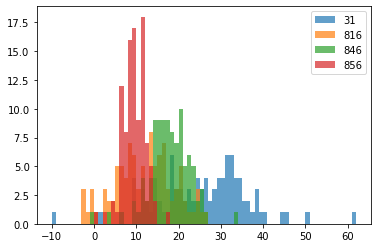

In [20]:
pm, mid = train_model(500,dropout = 0.1)
t[mid],s[mid], e[mid] = eval_model(pm, test_ds)
p[mid] = pm

mae = raw_eval(t[mid],s[mid])

run_test(t[mid], s[mid], [31,816,846,856])

idx: 31 t: 18 p: 24
idx: 816 t: 20 p: 11
idx: 846 t: 21 p: 17
idx: 856 t: 11 p: 9


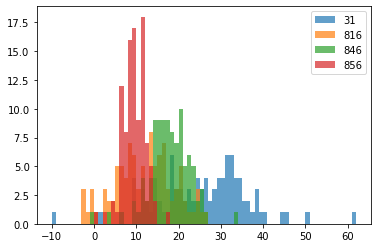

In [21]:
run_test(t[mid], s[mid], [31,816,846,856])

In [26]:
save_full_pitmodel(mid, 'all')

make full testdb: 1830 records


Running evaluation: 100%|██████████| 1830/1830 [00:10<00:00, 170.78it/s]


{
    "MSE": 0.7731969228788884,
    "abs_error": 1333.656721007439,
    "abs_target_sum": 2966.1651649956075,
    "abs_target_mean": 1.6208552814183648,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.6198420666028964,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 546.8604449627725,
    "Coverage[0.1]": 0.44808743169398907,
    "QuantileLoss[0.5]": 1333.656721007439,
    "Coverage[0.5]": 0.7524590163934426,
    "QuantileLoss[0.9]": 760.8667135679584,
    "Coverage[0.9]": 0.7912568306010929,
    "RMSE": 0.8793161677570182,
    "NRMSE": 0.5425013434805563,
    "ND": 0.44962321611292133,
    "wQuantileLoss[0.1]": 0.1843661477170582,
    "wQuantileLoss[0.5]": 0.44962321611292133,
    "wQuantileLoss[0.9]": 0.256515288678837,
    "mean_wQuantileLoss": 0.2968348841696055,
    "MAE_Coverage": 0.23642987249544625
}
save model pitmodel-m60-mlp-dall-e500-l10-10-5-student-d0.1.pickle with 1830 keys.


Running evaluation: 100%|██████████| 3638/3638 [00:19<00:00, 182.28it/s]


{
    "MSE": 0.40147687182793795,
    "abs_error": 1727.264953942361,
    "abs_target_sum": 3779.0495181689503,
    "abs_target_mean": 1.03877117046975,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.7341374790495121,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 613.4820881473909,
    "Coverage[0.1]": 0.07174271577789995,
    "QuantileLoss[0.5]": 1727.264953942361,
    "Coverage[0.5]": 0.19461242440901594,
    "QuantileLoss[0.9]": 1598.6573588345072,
    "Coverage[0.9]": 0.44310060472787244,
    "RMSE": 0.6336220259965226,
    "NRMSE": 0.6099726715653727,
    "ND": 0.45706332918846393,
    "wQuantileLoss[0.1]": 0.1623376685586907,
    "wQuantileLoss[0.5]": 0.45706332918846393,
    "wQuantileLoss[0.9]": 0.42303159859336775,
    "mean_wQuantileLoss": 0.34747753211350746,
    "MAE_Coverage": 0.2635147516950706
}
mae =  4.658878504672897
idx: 31 t: 31 p: 27
idx: 816 t: 44 p: 28
idx: 846 t: 14 p: 9
idx: 856 t: 4 p: 1


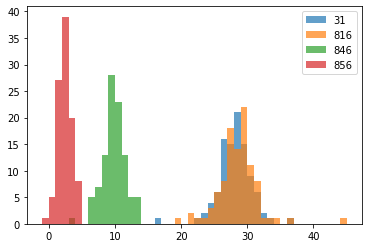

In [28]:
runid = 'sel'
#trainset, testset, train_ds, test_ds, scaler = _data[runid]
#pm, mid = train_model(500,dropout = 0.1, id = runid)
t[mid],s[mid], e[mid] = eval_model(pm,test_ds)
p[mid] = pm
mae = raw_eval(t[mid],s[mid])
run_test(t[mid], s[mid], [31,816,846,856])

idx: 31 t: 31 p: 27
idx: 816 t: 44 p: 28
idx: 846 t: 14 p: 9
idx: 856 t: 4 p: 1


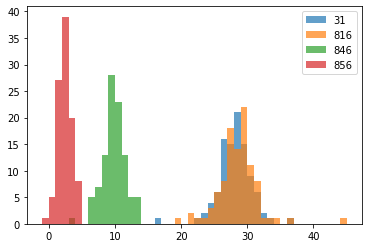

In [29]:
run_test(t[mid], s[mid], [31,816,846,856])

In [30]:
len(test_all)

4920

In [31]:
#mid =  'mlp-dsel-e500-l10-10-5-student-d0.1'
save_full_pitmodel(mid, 'sel', maxgap=65)

make full testdb: 2145 records


Running evaluation: 100%|██████████| 2145/2145 [00:12<00:00, 174.72it/s]


{
    "MSE": 1.4126874378783432,
    "abs_error": 2116.3819956522934,
    "abs_target_sum": 3779.5638833230714,
    "abs_target_mean": 1.7620344444396603,
    "seasonal_error": NaN,
    "MASE": NaN,
    "sMAPE": 0.7475020353194095,
    "MSIS": NaN,
    "QuantileLoss[0.1]": 2419.7226531269066,
    "Coverage[0.1]": 0.627972027972028,
    "QuantileLoss[0.5]": 2116.3819956522934,
    "Coverage[0.5]": 0.661072261072261,
    "QuantileLoss[0.9]": 1264.6830327334515,
    "Coverage[0.9]": 0.6881118881118881,
    "RMSE": 1.1885652854926998,
    "NRMSE": 0.67454145930199,
    "ND": 0.559954021412525,
    "wQuantileLoss[0.1]": 0.6402121323583598,
    "wQuantileLoss[0.5]": 0.559954021412525,
    "wQuantileLoss[0.9]": 0.3346108365342712,
    "mean_wQuantileLoss": 0.5115923301017187,
    "MAE_Coverage": 0.3003108003108003
}
save model pitmodel-m65-mlp-dsel-e500-l10-10-5-student-d0.1.pickle with 2145 keys.


In [ ]:
sys.exit(0)

### test and tuning

In [ ]:
s.keys()

In [ ]:
pm, mid = train_model(500,dropout = 0.1)
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
pm, mid = train_model(2000,dropout = 0.1)
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
save_model(p[mid], mid)
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
mid

In [ ]:
t.keys()

In [ ]:
pm, mid = train_model(200,dropout = 0.1, layers=[8,4])
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
e={}

In [ ]:
t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
pm, mid = train_model(500, layers=[10,5])
t[mid],s[mid] = eval_model(pm)
p[mid] = pm

In [ ]:
pm, mid = train_model(500, layers=[32,16,8,4])
t[mid],s[mid] = eval_model(pm)
p[mid] = pm

In [ ]:
run_test(t[mid], s[mid], [31,816,846,856])

In [ ]:
pm, mid = train_model(2000, layers=[32,16,8,4])
t[mid],s[mid] = eval_model(pm)
p[mid] = pm
run_test(t[mid], s[mid], [31,816,846,856])

### test

In [ ]:
trec = next(iter(train_ds))
trec


In [ ]:
run_test(tss, forecasts, [31,816,846,856])

In [ ]:
test_sel.iloc[816]

In [ ]:
test_sel.iloc[836]

In [ ]:
t[mid],s[mid] = eval_model(pm)

In [ ]:
get_pred(t[mid],s[mid], 816)

In [ ]:
next(iter(test_ds))

In [ ]:
scaler

In [ ]:
pm, mid = train_model(2,dropout = 0.1)
#t[mid],s[mid], e[mid] = eval_model(pm)
p[mid] = pm
#run_test(t[mid], s[mid], [31,816,846,856])

#mid = 'mlp-e2000-l10-10-5-student-d0.1'
save_model(p[mid], mid)

### test pitmodel

In [ ]:
_scaler = scaler

In [ ]:
id = 'mlp-e2000-l10-10-5-student-d0.1'
t[id],s[id], e[id] = eval_model(p[id])

In [ ]:
forecasts = s[id]
tss = t[id]

scaler = _scaler
testset = test_sel[['lap2nextpit','caution_laps','pitage']].values

pitmodel = PitModel()

pitmodel.save_model('pitmodel_test', testset, forecasts, scaler)

In [ ]:
newcasts = pitmodel.forecast_ds(testset, forecasts)
scaler = _scaler
run_test(tss, newcasts, [31,816,846,856],raw_forecast=True)

In [ ]:
plt.plot(pitmodel.model['0-0'][0,:], pitmodel.model['0-0'][1,:])

In [ ]:
plt.plot(pitmodel.model['10-13'][0,:], pitmodel.model['10-13'][1,:])

In [ ]:
pitmodel.model['0-0'][0,:]

In [ ]:
scaler = _scaler
test_all = df_test[['lap2nextpit','caution_laps','pitage']].values
test_ds, _, test_set = makedb(test_all, scaler, perm=False)

id = 'mlp-e2000-l10-10-5-student-d0.1'
t[id],s[id], e[id] = eval_model(p[id])
forecasts = s[id]
tss = t[id]

pitmodel = PitModel()

pitmodel.save_model(f'mlp-{id}.pickle', test_all, forecasts, scaler)


In [ ]:
len(forecasts)

In [ ]:
testall_set

In [ ]:
scaler = _scaler
maxgap = 60
test_ds, _, test_set, test_all = make_fulltestdb(scaler, maxgap = maxgap)

id = 'mlp-e2000-l10-10-5-student-d0.1'

t[id],s[id], e[id] = eval_model(p[id])
forecasts = s[id]
tss = t[id]

pitmodel = PitModel()

pitmodel.save_model(f'pitmodel-m{maxgap}-{id}.pickle', test_all, forecasts, scaler)

In [ ]:
pitmodel.model['0-0'][0,:]

In [ ]:
plt.plot(pitmodel.model['0-0'][0,:], pitmodel.model['0-0'][1,:])

In [ ]:
t.keys()

In [ ]:
t['mlp-dsel-e500-l10-10-5-student-d0.1'][0]